# Contextual Bandit in TSMC Stock Trading

In this notebook, we present how to use striatum package to conduct contextual bandit experiments with application to the stock trading. We first import the required packages, including pandas, numpy, matplotlib, and striatum.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from striatum.storage import (history, model, action)
from striatum.bandit import LinUCB
from striatum.storage.action import Action

Now, import the data set. The data sets contains the closed price, weekly log return, and 14 trading information variables of TSMC stock. The data set is downloaded from the TEJ database.

The training period starts from week 0 (2011/9/2) to week 204 (2015/8/14), totally 205 weeks. The testing period starts from week 205 (2015/8/17) to week 257 (2016/8/19), totally 53 weeks.

Also, we apply the Z normalization on our context variables. Note that the normalization is based on the training period so that no future information is used.

In [2]:
data = pd.read_table('data4.csv', sep=',', encoding='cp950', index_col=0)
data.head(5)

,未調整收盤價(元),週報酬率 %,外資買賣超(張),投信買賣超(張),自營買賣超(張),融資增加(張),融資減少(張),融券增加(張),融券減少(張),外資連續累計買賣超(張),投信連續累計買賣超(張),自營連續累計買賣超(張),法人連續累計買賣超(張),外資成交比重,投信成交比重,自營成交比重,法人成交比重,信用交易比重
年月日,,,,,,,,,,,,,,,,,,
2011/9/2,67.5,-0.005891,-18857,566,-254,3381,0,0,480,-18857,1499,-4313,-18545,60.88,1.48,3.43,65.79,3.66
2011/9/9,69.3,0.026667,13837,1000,185,0,1304,392,0,25918,11969,185,36486,58.55,1.31,3.39,63.25,2.42
2011/9/16,71.1,0.025975,41631,-1338,64,0,1966,949,0,55491,-1338,6913,60819,49.31,4.31,2.26,55.88,1.34
2011/9/23,67.5,-0.050633,-24091,4092,4000,2404,0,35,0,-50452,5457,5845,-40820,62.85,2.36,4.09,69.29,4.02
2011/9/30,70.0,0.037038,4240,869,-829,711,0,0,389,55988,869,-3172,57407,73.68,1.55,1.55,76.77,2.83


In [3]:
for i in range(2,18):
    mean = np.average(data.iloc[0:204, i])
    std = np.std(data.iloc[0:204, i])
    data.iloc[:, i] = (data.iloc[:, i] - mean) / std

The next step is initializing the contextual bandit learner. Here we have two actios - 'long' and 'short'. The history_stroage object is used to store contexts, recommendations, and rewards histories. The model_storage is used to store parameters of the LinUCB learner.

Here, our policy is LinUCB (Li et. al, 2010) with tunning parameter alpha = 0.4. Note that I haven't tried to tune the parameter. If you're interested, try to find the optimal alpha for this data set.

In [4]:
action_storage = action.MemoryActionStorage()
action_storage.add([Action(1, 'long'), Action(2, 'short')])

history_storage = history.MemoryHistoryStorage()
model_storage = model.MemoryModelStorage()
policy = LinUCB(history_storage=history_storage,
                model_storage=model_storage,
                action_storage=action_storage,
                context_dimension=14,
                alpha=0.4)

Now, we'll squentially train the learner. We use the 14 trading information variables at time i as our context, and derive the recommended action to do at time i + 1, and update the reward of this action by the log return at time i + 1.

In [5]:
for i in range(0, 257):
    context = data.iloc[i, 2:16].tolist()
    context = {1: context, 2: context}
    history_id, recommendation = policy.get_action(context)
    action_id = recommendation.action.id
    if action_id == 1:
        (history_id, {action_id: data.iloc[i + 1, 1]})
        policy.reward(history_id, {action_id: data.iloc[i + 1, 1]})
    elif action_id == 2:
        policy.reward(history_id, {action_id: -1 * data.iloc[i + 1, 1]})

Now, we extract the historical actions, scores, and rewards.

In [6]:
last_history_id = policy.history_storage.n_histories
rewards = np.zeros(last_history_id)
actions = np.zeros(last_history_id)
scores = np.zeros(last_history_id)
for i in range(0, last_history_id):
    rewards[i] = policy.history_storage.get_history(i).recommendations.reward
    actions[i] = policy.history_storage.get_history(i).recommendations.action.id
    scores[i] = policy.history_storage.get_history(i).recommendations.score

actions = actions.astype("int")

The traiding strategy is:
(1) Only try to change position when the log return of this week > 0.685%. If the reward is < 0.685%, do not change the position, and no transaction fee is required. 
(2) If the recommended action is the same as the current week, do not change the position.
(3) When we need to change our position, the transaction fee is incurred. (Long: 0.585%, Short: 0.685%.)
Now, we calculate the cumulative wealth of the LinUCB strategy for the testing period.

In [7]:
cum_wealth = np.zeros(53)
current_position = actions[204]
cum_wealth[0] = 121 * (1-0.00585)
for i in range(0, 52):
    if rewards[i + 204] > 0.00685:
        if actions[i + 204] == 2 & actions[i + 205] == 1:
            cum_wealth[i + 1] = cum_wealth[i] * (1 + rewards[i + 204] - 0.00685)
            current_position = 1
        elif actions[i + 204] == 1 & actions[i + 205] == 2:
            cum_wealth[i + 1] = cum_wealth[i] * (1 + rewards[i + 204] - 0.00585)
            current_position = 2
        else:
            cum_wealth[i + 1] = cum_wealth[i] * (1 + rewards[i + 204])
            current_position = actions[i + 205]
    else:
        if  current_position == actions[i + 205]:
            cum_wealth[i + 1] = cum_wealth[i] * (1 + rewards[i + 204])
        else:
            cum_wealth[i + 1] = cum_wealth[i] * (1 - rewards[i + 204])

Finally, we can compare the LinUCB strategy with the single buy-and-hold strategy. It outperforms the single strategy.

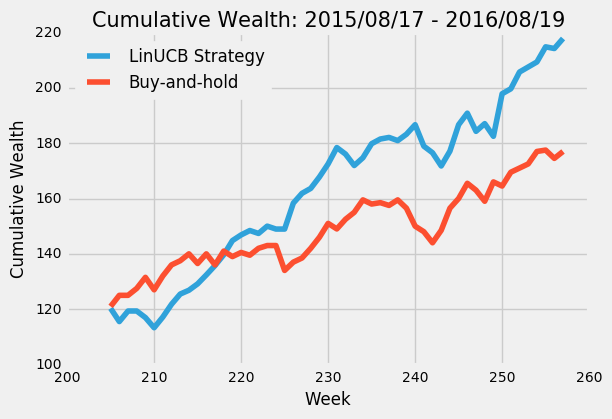

In [8]:
plt.style.use('fivethirtyeight')
plt.plot(range(205, 258), cum_wealth, label="LinUCB Strategy")
plt.plot(range(205, 258), data.iloc[205:258, 0], label="Buy-and-hold")
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.legend(loc="upper left", fancybox=True, fontsize= 12)
plt.xlabel('Week', fontsize= 12)
plt.ylabel('Cumulative Wealth', fontsize= 12)
plt.title("Cumulative Wealth: 2015/08/17 - 2016/08/19", fontsize= 15)
plt.show()

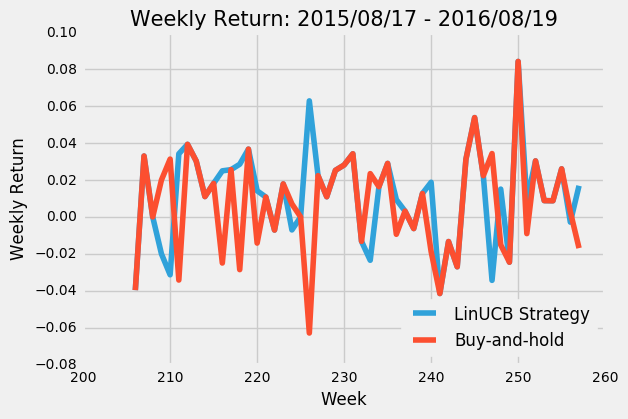

In [9]:
returns = [(cum_wealth[i] - cum_wealth[i - 1]) / cum_wealth[i - 1] for i in range(1, 53)]
plt.style.use('fivethirtyeight')
plt.plot(range(206, 258), returns, label="LinUCB Strategy")
plt.plot(range(206, 258), data.iloc[205:257, 1], label="Buy-and-hold")
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.legend(loc="lower right", fancybox=True, fontsize = 12)
plt.xlabel('Week', fontsize = 12)
plt.ylabel('Weekly Return', fontsize = 12)
plt.title("Weekly Return: 2015/08/17 - 2016/08/19", fontsize = 15)
plt.show()